In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json
from scipy.spatial.distance import hamming
import copy

In [2]:
#To ensure reproducibility
random.seed(11)
np.random.seed(11)

In [3]:
"""

This function calculate the average image from each category and find the image 
from each category which is furthest on average from the average image of  
each other category using Hamming distance as the distance metric. The idea was to
increase the accuracy of the Hopfield network and facilitate learning.

"""

def maximally_distant(images, labels):
    patterns = np.zeros((10, 784))
    inclass = []
    avg_category_im = np.zeros((10, 784))
    for category in range(0, 10):
        inclass.append([i for i in range(labels.shape[0]) if labels[i] == category])
        avg_category_im[category, :] = np.average([images[i, :] for i in inclass[category]], 0)
    
    #Find images from other categories that are maximally distant from average image already in the set
    for category in range(0, 10):
        distance = 0
        image = 0
        for j in range(len(inclass[category])):
            avg_distance = 0
            for c in range(10):
                if c != category:
                    avg_distance += hamming(images[inclass[category][j],:], avg_category_im[c,:])
            avg_distance /= 9
            if avg_distance > distance:
                distance = avg_distance
                image = inclass[category][j]
        patterns[category,:] = images[image, :]
    
    return transform(patterns)

"""
This function returns a set of images that contains 1s and -1s
"""
def transform(patterns):
    for i in range(len(patterns)):
        patterns[i,:] = -2.0*(patterns[i,:] > 0) +1
    return patterns

"""
This function was an attempt to further differentiate the images by padding them with 1s
and shifting them within the enlarged matrix, also increasing the number of units from 784 to 1600
"""
def new_shape(position, image):
    new_im = np.zeros((40,40))
    for x in range(40):
        for y in range(40):
            if x>=position[0] and x<28 and y>=position[1] and y<28:
                new_im[x,y] = image[x,y]
            else:
                new_im[x,y] = 1
    return new_im.reshape((40*40))  

In [4]:
# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

# Get the data into arrays
images = train_set[0]
labels = train_set[1]

image_preprocessing = False #Flag that allows to do image preprocessing 

#Put aside an array for the patterns
if image_preprocessing:
    patterns_ = maximally_distant(images, labels)
    patterns = np.zeros((10,1600))
    y = 0
    for img in range(10):
        patterns[img,:] = new_shape([random.randint(2,10), 
                                     random.randint(0,10)], 
                                    patterns_[img, :].reshape((28,28)))
    shape = (40,40)
    size = 1600
else:
    patterns = np.zeros((10,784))
    #Set aside one image per class to store (10 images in total)
    for category in range(10):
        inclass = [i for i in range(labels.shape[0]) if labels[i] == category]
        patterns[category,:] = -2.0*(images[inclass[random.randint(0,len(inclass))],:] > 0) +1
    shape = (28,28)
    size = 784

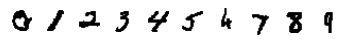

In [5]:
#Plot the patterns we're going to store
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(patterns[c,:].reshape(shape), cmap='gray')
    axs[c].axis("off")
plt.show()

In [6]:
class hopfield_network(object):
    """
    Define a class for a Hopfield network here.
    You must also define the functions below, but you can add additional arguments, etc.
    Also, note that you are welcome to write your own helper functions. 
    Reminder: you should use numpy functions for vector and matrix operations. No autograd!
    """
    
    # The initialization function for the hopfield network
    def __init__(self,N):
        """
        Comment!!!! Your marks depend on it!
        
        Notes: 
         - N is the number of units
         - You must have a variable 'state' that represents the current network state
        """    
        #Number of nodes
        self.n = N
        
        # the current state of the network
        self.state = np.zeros((N,))
        
        # Weight matrix    
        self.W = np.zeros((N,N))
        
        #Thresholds
        self.thresh = np.zeros((N,))
        
        #Learning rate
        self.eta = 1/N 
        
        #self.eta = 0.1. Another potential value informed by the number of memories stored.

    
    # The function for setting the activity state of the network
    def set_state(self,activity):
        """
        set_state(activity)
        
        Sets the state of the network to the pattern given by activity.
        
        You do not need to change this function.
        """
        
        # set the state to activity
        self.state = copy.deepcopy(activity)
        
    # The function for updating the state of the network
    def update(self):
        """
        Comment!!!! Your marks depend on it!
        """
        #Define a random sequence to update the node states
        update_seq = [node for node in range(self.n)]
        random.shuffle(update_seq)
        update_seq = update_seq[0:int(self.n/4)] # Only update half of nodes every time
        #For each node, use the threshold to set the state to 1 or -1
        for node in update_seq:
            net = (self.W[node, :]@self.state) 
            if net > self.thresh[node]:
                self.state[node] = 1
            else:
                self.state[node] = -1
                    
        # return the state for easy storage
        return self.state
    
    # The function for storing one image at a time
    def store_one(self,image):
        """
        Comment!!!! Your marks depend on it!
        """
        
        #Original weight update rule from 1982 paper
        #for i in range(self.n):          
            #for j in range(self.n):
                #if i != j :
                    #self.W[i,j] += self.eta*4*(image[i]-0.5)*(image[j]-0.5)
                    #self.W[j,i] += self.eta*4*(image[i]-0.5)*(image[j]-0.5)
            
        #Weight update using the equations as seen in class 
        #Multiply the current weight (node) by all j nodes where j != node and store that vector as the ith row 
        #and the ith column. The method below guarantees to maintain the zero diagonal. 
        image_copy = copy.deepcopy(image)
        for i in range(self.n-1):
            deltaW = self.eta*(image_copy[i]*image_copy[i+1:])
            self.W[i, i+1:] += deltaW
            self.W[i+1:, i] += deltaW.T  
        
        #Thresholds are calculated using the update rule as seen in class
        self.thresh -= self.eta*np.array(image)
        
        #Verify that the weight matrix is symmetric
        assert np.array_equal(self.W, self.W.T)
    
    # The function for storing multiple images in one shot
    def store_multi(self,images):
        """
        Comment!!!! Your marks depend on it!
        """
        #Here instead of looping, the algorithm makes use of matrix operations
        #First calculate the dot product between the image transpose and the images
        #Sums across images as desired and gets rid of self-weights
        
        self.W = self.eta*(images.T @ images)
        np.fill_diagonal(self.W, 0)
        self.thresh -= self.eta*np.array(sum(images))
        
        #Sanity check
        assert self.thresh.shape == (self.n,)

In [7]:
# Some helper functions for generating test images

# The function for generating a noisy version of an image
def image_noise(image,noise_level=0.1):
    """
    new_image = test_noise(image)
        
    This function takes an image, adds noise to it, and returns it. 

    noise_level - between 0-1, try experimenting with this

    """
    #Here, the algorithm first transforms the image back to binary, applies noise
    #and returns the image with 1s and -1s
    image = (image -1)/-2.0
    # create a mask for adding noise to the image
    image_mask = random.uniform(size=image.shape) < noise_level
    image = np.logical_xor(image,image_mask)
    return -2.0*image +1
    
# The function for generating a combo of two images
def image_combo(image1,image2,image1_weight=0.5):
    """
    newimage = test_combo(image1,image2)
        
    This function takes a pair of images, combines them, and returns the result.
    
    image1_weight - between 0-1, try experimenting with this

    """
    
    #Here, the algorithm first transforms the image back to binary, applies combination
    #and returns the image with 1s and -1s
    image1 = (image1 -1)/-2.0
    image2 = (image2 -1)/-2.0
    
    # create a mask for mixing the images
    image1_mask = random.uniform(size=image1.shape) < image1_weight
    combo = image1_mask*image1 + (1-image1_mask)*image2
    return -2.0*(combo) +1

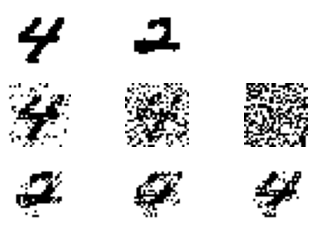

In [8]:
# Selfnotes: test different images by varying noise and combo images weight
# Test the helper functions to make sure they work

# Pick some random images
image1 = patterns[random.randint(0,10)]
image2 = patterns[random.randint(0,10)]

# Create a little array for storage
test_images = np.zeros((2,3,size))

# Generate a series of noise images
test_images[0,0,:] = image_noise(image1)
test_images[0,1,:] = image_noise(image1,noise_level=0.3)
test_images[0,2,:] = image_noise(image1,noise_level=0.5)

# Generate a series of combo images
test_images[1,0,:] = image_combo(image1,image2,image1_weight=0.2)
test_images[1,1,:] = image_combo(image1,image2)
test_images[1,2,:] = image_combo(image1,image2,image1_weight=0.8)

# Plot the images, plus the originals on top
fig, axs = plt.subplots(3,3)
axs[0,0].imshow(image1.reshape(shape), cmap='gray')
axs[0,0].axis("off")
axs[0,1].imshow(image2.reshape(shape), cmap='gray')
axs[0,1].axis("off")
axs[0,2].axis("off")
for c in range(3):
    axs[1,c].imshow(test_images[0,c,:].reshape(shape), cmap='gray')
    axs[1,c].axis("off")
    axs[2,c].imshow(test_images[1,c,:].reshape(shape), cmap='gray')
    axs[2,c].axis("off")
plt.show()

In [9]:
# Create a Hopfield network and train it

one_pattern = False # flag for whether to store one pattern at a time

hnet = hopfield_network(size) # construct the network

if one_pattern:
    # Train the network to store all the patterns using your store_one function
    for i in range(0, 10):
        hnet.store_one(patterns[i,:])
else:
    # Train the network to store all the patterns using your store_multi function 
    hnet.store_multi(patterns)

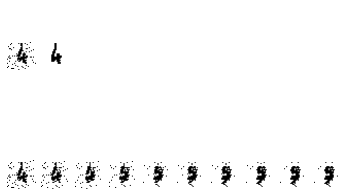

Distance between recalled pattern and original pattern: 0.14795918367346939


In [10]:
# Plot generated images from your Hopfield network as it updates after receiving an initial pattern that is
# a noisy version of an image that was stored

# number of time-steps to run the network for
numsteps = 10 # feel free to change this

# create an array for storing activity states over time
activity = np.zeros((numsteps, size))


# test using a noisy version of a random image
rand_image = patterns[random.randint(0,10),:]
activity[0,:] = image_noise(rand_image)
hnet.set_state(activity[0,:])
for t in range(numsteps-1):
    activity[t+1,:] = hnet.update()

# plot the results
fig, axs = plt.subplots(2,numsteps)
axs[0,0].imshow(activity[0,:].reshape(shape), cmap='gray')
axs[0,1].imshow(rand_image.reshape(shape), cmap='gray')
for c in range(numsteps):
    axs[1,c].imshow(activity[c,:].reshape(shape), cmap='gray')
    axs[0,c].axis("off")
    axs[1,c].axis("off")
plt.show()
print('Distance between recalled pattern and original pattern: {}'.format(hamming(activity[numsteps-1,:], activity[0,:])))

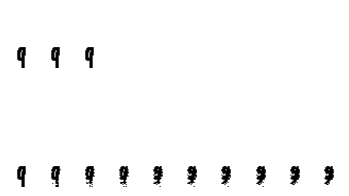

Distance between recalled pattern and first pattern in combination: 0.06760204081632654
Distance between recalled pattern and second pattern in combination: 0.06760204081632654


In [11]:
# Plot generated images from your Hopfield network as it updates after receiving an initial pattern that is
# a combination of two images that were stored

# number of time-steps to run the network for
numsteps = 10 # feel free to change this

# create an array for storing activity states over time
activity = np.zeros((numsteps,size))

# test using a combo of two random images
rand_image1 = patterns[random.randint(0,10),:]
rand_image2 = patterns[random.randint(0,10),:]
activity[0,:] = image_combo(rand_image1,rand_image2)
hnet.set_state(activity[0,:])
for t in range(numsteps-1):
    activity[t+1,:] = hnet.update()

# plot the results
fig, axs = plt.subplots(2,numsteps)
axs[0,0].imshow(activity[0,:].reshape(shape), cmap='gray')
axs[0,1].imshow(rand_image1.reshape(shape), cmap='gray')
axs[0,2].imshow(rand_image2.reshape(shape), cmap='gray')
for c in range(numsteps):
    axs[1,c].imshow(activity[c,:].reshape(shape), cmap='gray')
    axs[0,c].axis("off")
    axs[1,c].axis("off")
plt.show() 
print('Distance between recalled pattern and first pattern in combination: {}'.format(hamming(activity[numsteps-1,:], rand_image1)))
print('Distance between recalled pattern and second pattern in combination: {}'.format(hamming(activity[numsteps-1,:], rand_image2)))

In [12]:
"""
Train a hopfield network on random patterns with a minimum Hamming distance 0f 0.5
This allows us to generate a quasi-orthogonal set of patterns increasing the 
network's capacity and recall accuracy
"""
patterns_ = np.zeros((10, 100))
min_dist = 0.5
for p in range(10):
    d = 0
    while d < min_dist:
        rand_p = random.randint(2, size=100)
        d = sum([hamming(rand_p, patterns_[i,:]) for i in range(10)])/10 #Average Hamming distance
    patterns_[p,:] = rand_p
patterns_ = transform(patterns_)

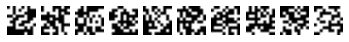

In [13]:
#Plot the patterns we're going to store
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(patterns_[c,:].reshape((10,10)), cmap='gray')
    axs[c].axis("off")
plt.show()

In [14]:
hnet2 = hopfield_network(100)
hnet2.store_multi(patterns_)

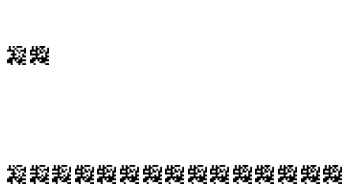

Distance between recalled pattern and original pattern: 0.12


In [15]:
# Plot generated images from the second Hopfield network as it updates after receiving an initial pattern that is
# a noisy version of an image that was stored

# number of time-steps to run the network for
numsteps = 15 # feel free to change this

# create an array for storing activity states over time
activity = np.zeros((numsteps, 100))


# test using a noisy version of a random image
rand_image = patterns_[random.randint(0,10),:]
activity[0,:] = image_noise(rand_image)
hnet2.set_state(activity[0,:])
for t in range(numsteps-1):
    activity[t+1,:] = hnet2.update()

# plot the results
fig, axs = plt.subplots(2,numsteps)
axs[0,0].imshow(activity[0,:].reshape((10,10)), cmap='gray')
axs[0,1].imshow(rand_image.reshape((10,10)), cmap='gray')
for c in range(numsteps):
    axs[1,c].imshow(activity[c,:].reshape((10,10)), cmap='gray')
    axs[0,c].axis("off")
    axs[1,c].axis("off")
plt.show()  
print('Distance between recalled pattern and original pattern: {}'.format(hamming(activity[numsteps-1,:], activity[0, :])))

Interestingly, as can be seen when running the cell above, th Hopfield network performs very well at remembering random patterns with a little noise. In this case, it did not average across images.

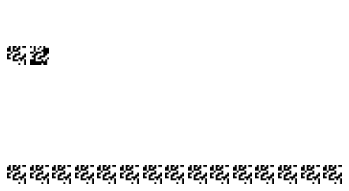

Distance between recalled pattern and original pattern: 1.0


In [16]:
#Present the complement to the net
rand_image = (patterns_[random.randint(0,10),:])
activity[0,:] = -2.0*np.logical_not((rand_image - 1)/-2.0) +1 
hnet2.set_state(activity[0,:])
for t in range(numsteps-1):
    activity[t+1,:] = hnet2.update()

# plot the results
fig, axs = plt.subplots(2,numsteps)
axs[0,0].imshow(activity[0,:].reshape((10,10)), cmap='gray')
axs[0,1].imshow(rand_image.reshape((10,10)), cmap='gray')
for c in range(numsteps):
    axs[1,c].imshow(activity[c,:].reshape((10,10)), cmap='gray')
    axs[0,c].axis("off")
    axs[1,c].axis("off")
plt.show()  
print('Distance between recalled pattern and original pattern: {}'.format(hamming(activity[numsteps-1,:], rand_image)))